<a href="https://colab.research.google.com/github/rufusclieve/DeepVision-Reconstruction/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training an Autoencoder and Classifier for Image Pixelation Detection and Classification**

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


input_shape = (64, 64, 3)
batch_size = 32
epochs = 50     # try this with 50 as we dont have support in our laptops

# Define the autoencoder model
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

autoencoder = build_autoencoder(input_shape)

# Prepare data
image_directory = '/content/drive/MyDrive/images_kaggle'

datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='input',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='input',
    subset='validation'
)

# Train the autoencoder
autoencoder.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Building a classifier using the trained encoder
def build_classifier(autoencoder, input_shape):
    # Extract the encoder
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=5).output)  # Adjust the index as per your encoder layers

    for layer in encoder.layers:
        layer.trainable = False

    model = Sequential()
    model.add(encoder)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

classifier = build_classifier(autoencoder, input_shape)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare data again for classification
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    image_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Train the classifier
classifier.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)



Found 1992 images belonging to 3 classes.
Found 498 images belonging to 3 classes.
Epoch 1/5
62/62 [==============================] - 74s 1s/step - loss: 0.6366 - val_loss: 0.5316
Epoch 2/5
62/62 [==============================] - 66s 1s/step - loss: 0.5545 - val_loss: 0.4994
Epoch 3/5
62/62 [==============================] - 66s 1s/step - loss: 0.5453 - val_loss: 0.4894
Epoch 4/5
62/62 [==============================] - 60s 969ms/step - loss: 0.5403 - val_loss: 0.4859
Epoch 5/5
62/62 [==============================] - 66s 1s/step - loss: 0.5364 - val_loss: 0.4775
Found 1992 images belonging to 3 classes.
Found 498 images belonging to 3 classes.
Epoch 1/5
62/62 [==============================] - 58s 929ms/step - loss: -51.9088 - accuracy: 0.4980 - val_loss: -146.4931 - val_accuracy: 0.5000
Epoch 2/5
62/62 [==============================] - 51s 828ms/step - loss: -254.4278 - accuracy: 0.4995 - val_loss: -484.7095 - val_accuracy: 0.4917
Epoch 3/5
62/62 [==============================] - 

# **Saving the Model**

In [7]:
autoencoder.save('autoencoder_model.h5')
classifier.save('classifier_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Image Reconstruction and Pixelation Classification using Autoencoder and Classifier Models**

1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 94ms/step


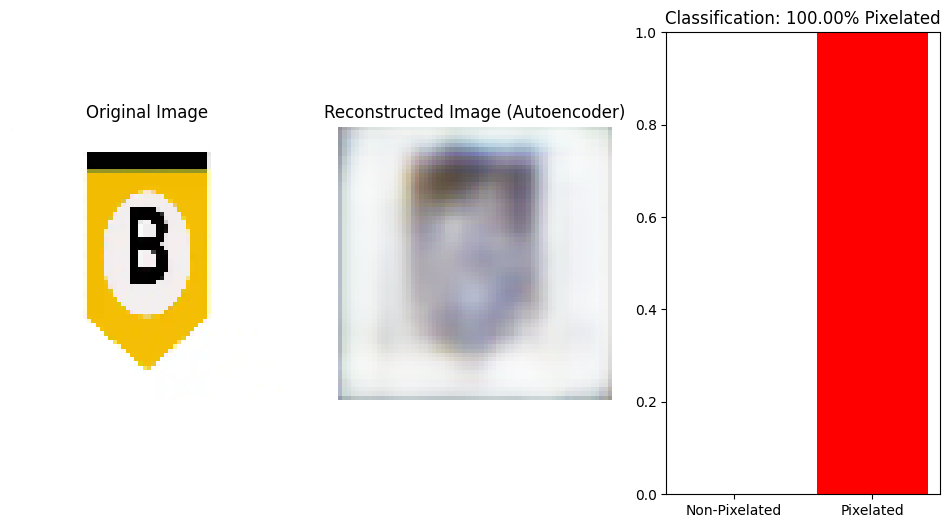

In [8]:

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained autoencoder and classifier models
autoencoder = load_model('autoencoder_model.h5')
classifier = load_model('classifier_model.h5')

# Load a single input image for testing
image_path = '/content/drive/MyDrive/images_kaggle/Original-1245/105.png'  # Replace with your image path
input_image = cv2.imread(image_path)
input_image = cv2.resize(input_image, (64, 64))  # Resize the image to match the input shape of the models
input_image_normalized = input_image / 255.0  # Normalize the image for the model
input_image_normalized = np.expand_dims(input_image_normalized, axis=0)  # Add batch dimension

# Test the autoencoder with the input image
reconstructed_image = autoencoder.predict(input_image_normalized)

# Test the classifier with the input image through the entire autoencoder
prediction = classifier.predict(input_image_normalized)

# Display the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
# Convert the original image (not the normalized one) to RGB for display
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.title('Reconstructed Image (Autoencoder)')
# The reconstructed image is already normalized, so no conversion needed
plt.imshow(reconstructed_image[0])
plt.axis('off')

# Classification Result
plt.subplot(1, 3, 3)
plt.title('Classification: {:.2f}% Pixelated'.format(prediction[0][0] * 100))
plt.bar(['Non-Pixelated', 'Pixelated'], [1 - prediction[0][0], prediction[0][0]], color=['green', 'red'])
plt.ylim(0, 1)

plt.show()

# **Evaluation of Pixelation Classification Performance Using F1 Score and Accuracy**

In [9]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Ensure the generator is reset before starting
validation_generator.reset()

# Generate predictions for the validation dataset
validation_steps = validation_generator.samples // batch_size
y_true = []
y_pred = []

for _ in range(validation_steps):
    x_val, y_val = next(validation_generator)
    y_true.extend(y_val)
    predictions = classifier.predict(x_val)
    y_pred.extend(predictions)

# Convert predictions to binary values (0 or 1)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary)
accuracy = accuracy_score(y_true, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


1/1 [==============================] - 0s 42ms/step
Accuracy: 0.5062
F1 Score: 0.6722


# **Assessing Model Sizes: Autoencoder and Classifier Model Sizes in Megabytes**

In [10]:
import os

def get_model_size(model_path):
    model_size_bytes = os.path.getsize(model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)  # Convert bytes to megabytes
    return model_size_mb

autoencoder_model_path = 'autoencoder_model.h5'
classifier_model_path = 'classifier_model.h5'

autoencoder_size_mb = get_model_size(autoencoder_model_path)
classifier_size_mb = get_model_size(classifier_model_path)

print(f'Autoencoder model size: {autoencoder_size_mb:.2f} MB')
print(f'Classifier model size: {classifier_size_mb:.2f} MB')


Autoencoder model size: 0.12 MB
Classifier model size: 1.54 MB


# **Pixelated Image Upscaling with the Ersan Algorithm**

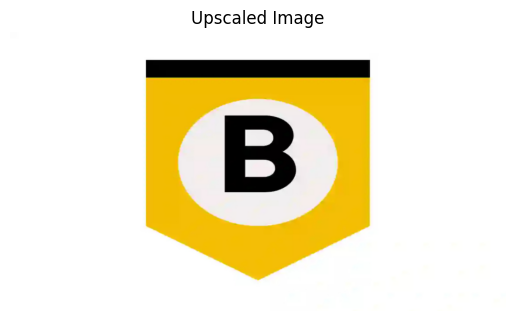

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ersan_upscale(image, scale_factor):
    """
    Upscale a pixelated image using the Ersan algorithm.

    Args:
        image (numpy.ndarray): The input pixelated image.
        scale_factor (int): The scale factor for upscaling the image.

    Returns:
        numpy.ndarray: The upscaled, non-pixelated image.
    """
    height, width, _ = image.shape
    new_height, new_width = height * scale_factor, width * scale_factor

    # Create a new image with the desired size
    upscaled_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    # Perform the Ersan upscaling algorithm
    for y in range(new_height):
        for x in range(new_width):
            # Calculate the corresponding pixel in the original image
            orig_x = x // scale_factor
            orig_y = y // scale_factor

            # Get the color values of the surrounding pixels in the original image
            top_left = image[orig_y, orig_x]
            top_right = image[orig_y, min(orig_x + 1, width - 1)]
            bottom_left = image[min(orig_y + 1, height - 1), orig_x]
            bottom_right = image[min(orig_y + 1, height - 1), min(orig_x + 1, width - 1)]

            # Interpolate the color values using the Ersan algorithm
            r = (top_left[0] * (scale_factor - x % scale_factor) * (scale_factor - y % scale_factor) +
                 top_right[0] * (x % scale_factor) * (scale_factor - y % scale_factor) +
                 bottom_left[0] * (scale_factor - x % scale_factor) * (y % scale_factor) +
                 bottom_right[0] * (x % scale_factor) * (y % scale_factor)) // (scale_factor * scale_factor)
            g = (top_left[1] * (scale_factor - x % scale_factor) * (scale_factor - y % scale_factor) +
                 top_right[1] * (x % scale_factor) * (scale_factor - y % scale_factor) +
                 bottom_left[1] * (scale_factor - x % scale_factor) * (y % scale_factor) +
                 bottom_right[1] * (x % scale_factor) * (y % scale_factor)) // (scale_factor * scale_factor)
            b = (top_left[2] * (scale_factor - x % scale_factor) * (scale_factor - y % scale_factor) +
                 top_right[2] * (x % scale_factor) * (scale_factor - y % scale_factor) +
                 bottom_left[2] * (scale_factor - x % scale_factor) * (y % scale_factor) +
                 bottom_right[2] * (x % scale_factor) * (y % scale_factor)) // (scale_factor * scale_factor)

            upscaled_image[y, x] = (r, g, b)

    return upscaled_image

# Load the pixelated image
image_path = '/content/drive/MyDrive/images_kaggle/Original-1245/105.png'
pixelated_image = cv2.imread(image_path)

if pixelated_image is None:
    raise FileNotFoundError(f"Cannot open/read file: {image_path}. Please check the file path/integrity.")

# Upscale the image using the Ersan algorithm
scale_factor = 2
upscaled_image = ersan_upscale(pixelated_image, scale_factor)

# Display the upscaled image using matplotlib
plt.imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
plt.title('Upscaled Image')
plt.axis('off')  # Hide axis
plt.show()


# **Saving the upsacalled image in directory**

In [2]:
# Save the upscaled image
output_image_path = '/content/drive/MyDrive/images_kaggle/Upscaled-105.png'
cv2.imwrite(output_image_path, cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
print(f"Upscaled image saved at: {output_image_path}")

Upscaled image saved at: /content/drive/MyDrive/images_kaggle/Upscaled-105.png


# **PSNR Evaluation for Original and Reconstructed Images After Upscaling**

In [3]:
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_psnr(image1, image2):
    # Ensure the images have the same shape
    assert image1.shape == image2.shape, "(1080,1920)"

    # Calculate PSNR
    psnr_value = psnr(image1, image2)
    return psnr_value

def check_and_calculate_psnr(original_image_path, reconstructed_image_path, target_shape=(1080, 1920)):
    # Load images
    original_image = cv2.imread(original_image_path)
    reconstructed_image = cv2.imread(reconstructed_image_path)

    # Check if either image is None (i.e., failed to load)
    if original_image is None:
        raise FileNotFoundError(f"Cannot open/read file: {original_image_path}. Please check the file path/integrity.")
    if reconstructed_image is None:
        raise FileNotFoundError(f"Cannot open/read file: {reconstructed_image_path}. Please check the file path/integrity.")

    # Resize both images to the target shape
    original_image_resized = cv2.resize(original_image, target_shape)
    reconstructed_image_resized = cv2.resize(reconstructed_image, target_shape)

    # Ensure the images have the same shape
    if original_image_resized.shape != reconstructed_image_resized.shape:
        raise ValueError("The resized images do not have the same dimensions.")

    # Calculate PSNR
    psnr_value = calculate_psnr(original_image_resized, reconstructed_image_resized)

    print(f"PSNR value: {psnr_value} dB")
    return psnr_value  # Optional: return PSNR value for further use

# Example usage
original_image_path = '/content/drive/MyDrive/images_kaggle/Original-1245/105.png'
reconstructed_image_path = '/content/drive/MyDrive/images_kaggle/Upscaled-105.png'

psnr_value = check_and_calculate_psnr(original_image_path, reconstructed_image_path)


PSNR value: 10.112909317947372 dB


# **Structural Similarity Index (SSIM) Comparison Between Original and Reconstructed Images**

In [6]:
from skimage import io
from skimage.metrics import structural_similarity as ssim
import cv2

# Load the images
original_image = io.imread('/content/drive/MyDrive/images_kaggle/Original-1245/105.png')
reconstructed_image = io.imread('/content/drive/MyDrive/images_kaggle/Upscaled-105.png')

# Ensure both images have the same number of color channels (3 for RGB)
if original_image.shape[2] == 4:  # Check if original image has an alpha channel
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)  # Convert to RGB

# Resize the reconstructed image to match the original image's dimensions
reconstructed_image = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))

# Compute SSIM
ssim_value = ssim(original_image, reconstructed_image, multichannel=True)

print(f"SSIM value: {ssim_value}")

<ipython-input-6-2c7c4d5416a1>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_image, reconstructed_image, multichannel=True)


SSIM value: 0.8778566624114926


In [8]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 926.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# **LPIPS Comparison Between Original and Resized Reconstructed Images**

In [10]:
import torch
import lpips
from PIL import Image
import numpy as np

# Load the images
def load_image(path):
    return Image.open(path).convert('RGB')

def preprocess_image(img):
    return (torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0) / 255.0 * 2 - 1).float()

original_image_path = '/content/drive/MyDrive/images_kaggle/Original-1245/105.png'
reconstructed_image_path = '/content/drive/MyDrive/images_kaggle/Upscaled-105.png'

original_image = load_image(original_image_path)
reconstructed_image = load_image(reconstructed_image_path)

# Resize the reconstructed image to match the original image's dimensions
reconstructed_image = reconstructed_image.resize(original_image.size)

# Preprocess images after resizing
original_image = preprocess_image(original_image)
reconstructed_image = preprocess_image(reconstructed_image)

# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='alex')  # You can also use 'vgg'

# Compute LPIPS
lpips_value = lpips_model(original_image, reconstructed_image)

print(f"LPIPS value: {lpips_value.item()}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS value: 0.1520923376083374
